# Data Analysis of Vietnam society of Cardiology Membership - Vietnam heart association - VNHA

## Scape data of memebers from their website
- Link: http://vnha.org.vn/member.asp
- Library: 
    - ```playwright``` for web navigation
    - ```beautifulsoup``` as a html parsers
    - The reason for using playwright is that the pagiation is created by JavaScript => we use the program to automate clicking on pagiation panel 
### Note
If you have to use the code generator feature (https://playwright.dev/python/docs/codegen) before scraping a web page by Playwright or when you use ```headless=False``` for testing and manual check up. You need to wait for the website to fully load.
- Add ```page.wait_for_timeout(50000)```
- The playwright builtin browser may not allow you to scroll manually so you can use ``` page.screenshot(path="screenshot.png", full_page=True)```
- Some websites detect bot, remember to add ```user_agent``` example:```browser.new_context(user_agent="Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/118.0.0.0 Safari/537.36")```
### Below are the code for the scarper but it can't run inside jupyter notebook because of incompatibility issue
- If you just want the data for analysis, here's the link to the kaggle files https://www.kaggle.com/datasets/flyingcamel/memberships-of-vnhavietnam-society-of-cardiology?select=Memberships+-+Vietnamese+headings+ver.csv
- If you want to run it yourself, you can download the python code of the scraper on my github or copy and paste the code below to another python script and run it locally https://github.com/reallyyy/VNHAMembershipScrapper

In [ ]:
from playwright.sync_api import sync_playwright, Playwright
from bs4 import BeautifulSoup
import re
import pandas as pd
import requests
def run(playwright: Playwright):
   chromium = playwright.chromium # or "firefox" or "webkit".
   browser = chromium.launch(headless=True)
   page = browser.new_page()
   page.goto("http://vnha.org.vn/member.asp")
   pagation = page.get_by_role("table").filter(has_text="trong tổng số").filter(has_not_text="TÌM KIẾM HỘI VIÊN").filter(has_not_text="Danh sách hội viên").filter(has_not_text="Hội viên chính thức")
   pattern = r"Trang \d+ trong tổng số \d+ trang \(\d+ tin\)"
   page_num_info = re.findall(pattern,pagation.all_inner_texts()[0])[0]
   page_num_info = re.findall(r"\d+",page_num_info)
   total_page_num = int(page_num_info[1]) # Get the total number of pages
   data = pd.DataFrame(columns=["Id","Tên Hội viên","Đơn vị","Ngày cập nhật","Link profile"])
   for i in range(total_page_num):
      print("Current page: " + str(i+1))
      if i != 0:
         pagation = page.get_by_role("table").filter(has_text="trong tổng số").filter(has_not_text="TÌM KIẾM HỘI VIÊN").filter(has_not_text="Danh sách hội viên").filter(has_not_text="Hội viên chính thức")
         pagation.get_by_text(">>").click()
         # another option is locate the button using CSS: page.locator('.paging').get_by_text(">>").click()
         page.wait_for_timeout(2000)
      html = page.inner_html("body")
      soup = BeautifulSoup(html,'html.parser')
      rows = soup.select('table > tbody > tr')
      for row in rows:
         cols = row.find_all('td')
         fields = [td.text.strip() for td in cols if td.text.strip()]
         if fields: # if the row is not empty
            try:
               fields[0] = int(fields[0])
            except:
               continue
         if len(fields) == 4:  
            fields_data = {
               'Id': fields[0],
               "Tên Hội viên":fields[1],
               "Đơn vị":fields[2],
               "Ngày cập nhật":fields[3],
               "Link profile":row.find("a")['href']
               }
         elif len(fields) == 3:
            fields_data = {
               'Id': fields[0],
               "Tên Hội viên":fields[1],
               "Ngày cập nhật":fields[2],
               "Link profile":row.find("a")['href']
               }
         else:
            continue
         fields_data = pd.DataFrame(fields_data,index=[0])
         data = pd.concat([data,fields_data],ignore_index = True)
   data.to_csv("list_of_members.csv",encoding='utf-16') # Panda doesn't work well in processing Vietnamese text by defauly encoding='utf-16' is important

with sync_playwright() as playwright:
   run(playwright)

def get_profile_detail(link_profiles):
   df = pd.DataFrame()
   for link_profile in link_profiles:
      print("Current profile: " + link_profile)
      data = pd.read_html("http://vnha.org.vn/"+link_profile)[-4]
      dict = {
         "Link profile": str(link_profile),
         "Chức vụ":data[1][2],
         "Địa chỉ":data[1][3],
         "Điện thoại cơ quan":data[1][4],
         "Email":data[1][5],
         "Tình trạng hội viên":data[1][6]
         }
      df = pd.concat([df,pd.DataFrame(dict,index=[0])],ignore_index = True)
   return df

memberships_data = pd.read_csv('list_of_members.csv',encoding='utf-16')
profile_details = get_profile_detail(memberships_data["Link profile"])
final_data = memberships_data.set_index("Link profile").join(profile_details.set_index("Link profile"))
final_data.to_csv("final_data.csv",encoding='utf-16')

In the first place, I tried to phrase the html content of the http://vnha.org.vn/member.asp page using beautifulSoup and then using panda to find the table of memberships. And then later I will access the profile details of memebers by looping like this and matching the info of the members to the table of memberships :
```
for id in range(64485+1):
        pd.read_html("http://vnha.org.vn/mprofile.asp?m_id="+id)
```

After a while I realized that the ```id``` in the url is only roughly a sequence, 1 st id is 64485 but the 3 rd id is 3007 and there are situations where profiles with lower ```id``` will appear first in the membership list on the initial http://vnha.org.vn/member.asp page. This apporoach will be less resitant to future changes of the website if the ```id``` continue to change in the future and will make the matching of profiles to members more difficult and more prone to error because pandas only returns table with pure text, removing the ```href``` element, thus losing the ```id``` profile of each memebers. That's why I choose the current approach of looping through rows and constructing the table manually which is a bit slower to code but is more robust.

## Analyze the data
I will be using the data I already scrapped.


In [61]:
import pandas as pd
import seaborn as sns
# !pip install langdetect
# !pip install underthesea
# !pip install geopy
from underthesea import ner
import matplotlib.pyplot as plt 
from langdetect import detect,detect_langs
membership_data = pd.read_csv("C:/Users/admin/Desktop/Memberships - English headings ver.csv",encoding="utf-8")

### Check for the distribution of last name in this population
#### First approach for getting data using NLP

In [62]:
vietnamese_doctor_names= [name for name in membership_data["Name"] if str(detect_langs(name)[0]).split(":")[0] == "vi" and float(str(detect_langs(name)[0]).split(":")[1]) > 0.8]
vietnamese_doctor_names = [name for name in vietnamese_doctor_names if 'B-PER' in str(ner(name))] # remove any enity that isn't a person 
vietnamese_doctor_last_names = [str(name.split(" ")[0]).lower().capitalize() for name in vietnamese_doctor_names]

#### Second approach for getting data manual

In [4]:
last_names = membership_data["Name"].apply(lambda name: str(name.split(" ")[0]).lower())
# print(last_names.unique().remove(['steven','yi-heng','young','sigmund','mark','yen','masahiko', 'tang', 'yoshiaki','vidang', 'philippe','arthur', 'kwan']))
vietnamese_common_last_names = ['nguyễn', 'trần', 'đinh', 'phan', 'phạm', 'hội', 'ngân', 'huỳnh', 'đàm', 'dương',
                         'chu', 'ngô', 'lã', 'lý', 'lê', 'đoàn', 'cao', 'đặng', 'vũ', 'vi', 'lâm', 'tăng',
                         'doãn', 'bùi', 'hoàng', 'đào', 'yen', 'tô', 'hà', 'trương', 'đỗ', 'lê', 'pham', 
                         'vo', 'ho', 'nguyễn', 'mai', 'đồ', 'nguyến', 'lưu', 'lương', 'văn', 'kim', 'vương', 
                         'phùng', 'võ', 'quang', 'hồng', 'trịnh', 'tran', 'nông', 'từ', 'cù', 'tu', 'thái', 
                         'trang', 'quyền', 'trác', 'liêu', 'hứa', 'viên', 'quách', 'trần', 'hán', 'tống', 
                         'châu', 'hùynh', 'trân', 'triệu', 'thọ', 'tôn', 'ninh', 'la', 'lữ', 'vĩnh', 'cái', 
                         'trinh', 'thiều', 'bạch', 'phương', 'khương', 'lư', 'diệp', 'ong', 'my', 'giao', 'hàn','nguyen', 'kiều','khổng', 'nghiêm','khung', 'khúc', 'giáp', 'lô', 'tạ', 'hồ','tư', 'bs','bá', 'thầy', 'cổ', 'ngọ','lại']
# print(list(last_names.unique()).remove(vietnamese_last_names))
foreign_doctor_last_names = [e for e in last_names.unique() if e not in vietnamese_common_last_names]
vietnamese_doctor_last_names = [e for e in last_names.unique() if e not in foreign_doctor_last_names]
#Manually check 
print(pd.array(vietnamese_doctor_last_names).value_counts())

nguyễn    1
tu        1
hán       1
trần     1
quách     1
         ..
kiều      1
nguyen    1
trương    1
hà        1
hàn       1
Name: count, Length: 103, dtype: Int64


#### Draw graphs of distributions of surnames

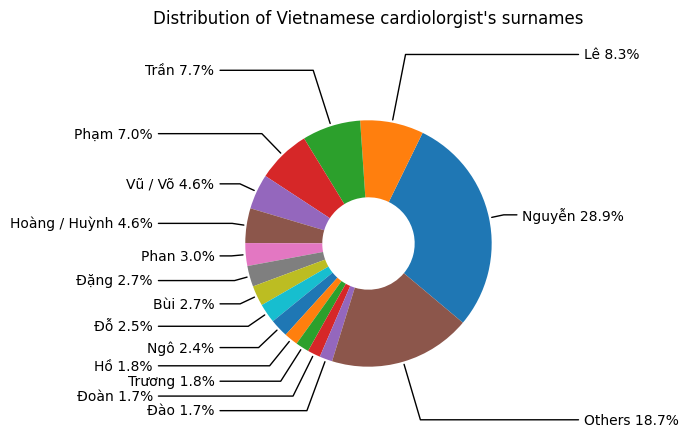

In [87]:
import numpy as np, math, random
import matplotlib.pyplot as plt
last_name_data_unique_counts = pd.Series(vietnamese_doctor_last_names).value_counts()
total = np.sum(last_name_data_unique_counts.values)
pct_data = {name:pct/total*100 for name,pct in last_name_data_unique_counts.items()}
new_row = {"Hoàng / Huỳnh":pct_data["Hoàng"]+pct_data["Huỳnh"],"Vũ / Võ":pct_data["Vũ"]+pct_data["Võ"]}
pct_data.update(new_row)
for i in ["Hoàng","Huỳnh","Vũ","Võ"]: pct_data.pop(i)
sorted_last_names_by_pct = sorted(pct_data.items(), key=lambda x:x[1],reverse=True)

pie_chart_data = dict(sorted_last_names_by_pct[:15]) # get the five most popular
others_row = {"Others":sum({name:pct for name,pct in dict(sorted_last_names_by_pct[15:]).items()}.values())}
pie_chart_data.update(others_row)

def draw_pie_chart(final_data,title=""):
    fig, ax = plt.subplots(figsize=(12, 5), subplot_kw=dict(aspect="equal"))
    plt.title(title,pad=20)
    recipe = list(final_data.keys())
    data = list(final_data.values())
    perc = [str(round(e / s * 100., 1)) + '%' for s in (sum(data),) for e in data]
    wedges, texts = ax.pie(data, wedgeprops=dict(width=0.5), startangle=-40, radius = 0.8,)
    bbox_props = dict(boxstyle="square,pad=0.3", fc="w", ec="k", lw=0.72)
    kw = dict(arrowprops=dict(arrowstyle="-"),
            #bbox=bbox_props,
            zorder=0, va="center")

    for i, p in enumerate(wedges):
        ang = (p.theta2 - p.theta1) / 2. + p.theta1
        y = np.sin(np.deg2rad(ang))
        x = np.cos(np.deg2rad(ang))
        yc = np.arcsin(y) / (np.pi / 2)
        horizontalalignment = {-1: "right", 1: "left"}[int(np.sign(x))]
        connectionstyle = f'angle,angleA=0,angleB={ang}'
        kw["arrowprops"].update({"connectionstyle": connectionstyle})
        ax.annotate(recipe[i] + ' ' + perc[i], xy = (0.8 * x, 0.8 * y), xytext = ((1.0 + (i % 2) * 0.4) * np.sign(x), 1.4 * yc),
                    horizontalalignment = horizontalalignment, **kw)
    plt.show()
draw_pie_chart(pie_chart_data,"Distribution of Vietnamese cardiolorgist's surnames")


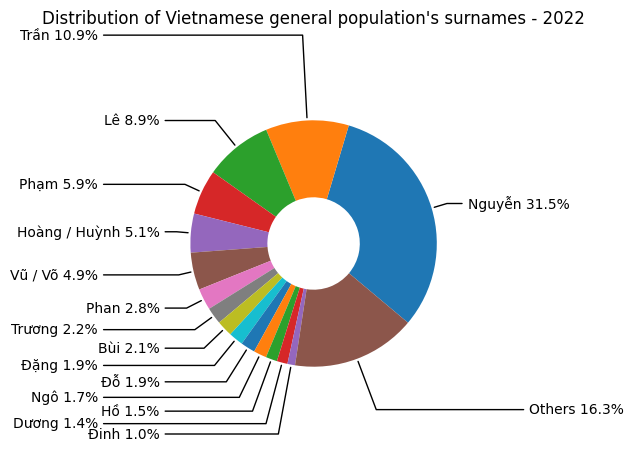

In [20]:
tables = pd.read_html("https://en.wikipedia.org/wiki/Vietnamese_name")
general_pop_data = dict(zip(tables[1]["Surname/Family name"],tables[1]["Percentage"].apply(lambda x:float(x[:-1]))))
new_row = {"Others":float(100 - sum(general_pop_data.values()))}
general_pop_data.update(new_row)
draw_pie_chart(general_pop_data,"Distribution of Vietnamese general population's surnames - 2022")

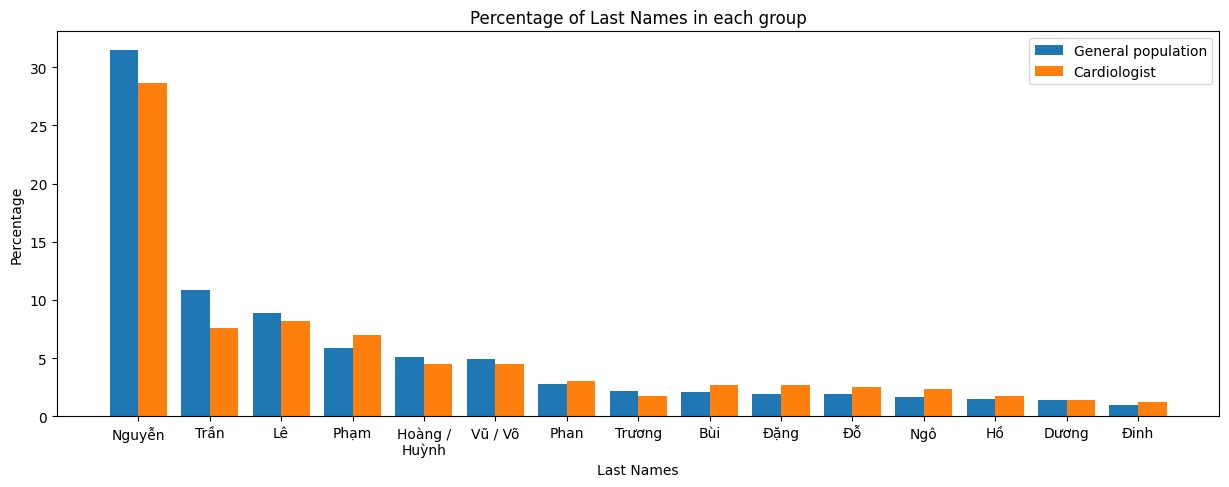

In [103]:
import textwrap
f = lambda x: textwrap.fill(x, 10)
a = pd.DataFrame(general_pop_data,index = [0])
# a["Type"] = "General population"
b = pd.DataFrame(dict(sorted_last_names_by_pct),index = [0])
#b["Type"] = "Cardiologist"
data = pd.concat([a,b],ignore_index=True).dropna(axis = 1)
X = data.columns
X_axis = np.arange(len(X))
plt.figure(figsize=(15,5))
plt.bar(X_axis - 0.2, list(np.array(data)[0]), 0.4, label = 'General population')
plt.bar(X_axis + 0.2, list(np.array(data)[1]), 0.4, label = 'Cardiologist') 
plt.xticks(X_axis, map(f,X)) 
plt.yticks()
plt.xlabel("Last Names") 
plt.ylabel("Percentage")
plt.title("Percentage of Last Names in each group") 
plt.legend()
plt.show() 

In [111]:
print(sum(np.array(data)[0][:3]))
print(sum(np.array(data)[1][:3]))

51.3
44.49423815620999


In [112]:
print(sum(np.array(data)[0][:6]))
print(sum(np.array(data)[1][:6]))

67.2
60.563380281690144
